# Heart Disease Logistic Regression Analysis

This notebook performs:
1. Data loading and target binarization
2. Exploratory Data Analysis (EDA)
3. Data preparation (train/test split, normalization)

**Note:** No high-level ML libraries (scikit-learn, statsmodels, TensorFlow, PyTorch) are used.

## 1. Import Libraries and Load Data

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('Heart_Disease_Prediction.csv')

# Display first few rows
print("Dataset Shape:", df.shape)
print("\nFirst 5 rows:")
df.head()

Dataset Shape: (270, 14)

First 5 rows:


,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
0,70,1,4,130,322,0,2,109,0,2.4,2,3,3,Presence
1,67,0,3,115,564,0,2,160,0,1.6,2,0,7,Absence
2,57,1,2,124,261,0,0,141,0,0.3,1,0,7,Presence
3,64,1,4,128,263,0,0,105,1,0.2,2,1,7,Absence
4,74,0,2,120,269,0,2,121,1,0.2,1,1,3,Absence


In [7]:
# Binarize the target column: 1 = Presence (disease), 0 = Absence (no disease)
df['Heart Disease Binary'] = df['Heart Disease'].map({'Presence': 1, 'Absence': 0})

# Verify the mapping
print("Target column mapping:")
print(df[['Heart Disease', 'Heart Disease Binary']].drop_duplicates())
print("\nTarget distribution:")
print(df['Heart Disease Binary'].value_counts())

Target column mapping:
  Heart Disease  Heart Disease Binary
0      Presence                     1
1       Absence                     0

Target distribution:
Heart Disease Binary
0    150
1    120
Name: count, dtype: int64


## 2. Exploratory Data Analysis (EDA)

In [8]:
# Summary statistics
print("="*60)
print("SUMMARY STATISTICS")
print("="*60)
print("\nDataset Info:")
print(df.info())
print("\n" + "="*60)
print("Descriptive Statistics:")
print("="*60)
df.describe()

SUMMARY STATISTICS

Dataset Info:
<class 'pandas.DataFrame'>
RangeIndex: 270 entries, 0 to 269
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      270 non-null    int64  
 1   Sex                      270 non-null    int64  
 2   Chest pain type          270 non-null    int64  
 3   BP                       270 non-null    int64  
 4   Cholesterol              270 non-null    int64  
 5   FBS over 120             270 non-null    int64  
 6   EKG results              270 non-null    int64  
 7   Max HR                   270 non-null    int64  
 8   Exercise angina          270 non-null    int64  
 9   ST depression            270 non-null    float64
 10  Slope of ST              270 non-null    int64  
 11  Number of vessels fluro  270 non-null    int64  
 12  Thallium                 270 non-null    int64  
 13  Heart Disease            270 non-null    str    
 14  Hea

,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease Binary
count,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.00000,270.000000,270.000000,270.000000,270.000000
mean,54.433333,0.677778,3.174074,131.344444,249.659259,0.148148,1.022222,149.677778,0.329630,1.05000,1.585185,0.670370,4.696296,0.444444
std,9.109067,0.468195,0.950090,17.861608,51.686237,0.355906,0.997891,23.165717,0.470952,1.14521,0.614390,0.943896,1.940659,0.497827
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.00000,1.000000,0.000000,3.000000,0.000000
25%,48.000000,0.000000,3.000000,120.000000,213.000000,0.000000,0.000000,133.000000,0.000000,0.00000,1.000000,0.000000,3.000000,0.000000
50%,55.000000,1.000000,3.000000,130.000000,245.000000,0.000000,2.000000,153.500000,0.000000,0.80000,2.000000,0.000000,3.000000,0.000000
75%,61.000000,1.000000,4.000000,140.000000,280.000000,0.000000,2.000000,166.000000,1.000000,1.60000,2.000000,1.000000,7.000000,1.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.20000,3.000000,3.000000,7.000000,1.000000


In [9]:
# Check for missing values
print("="*60)
print("MISSING VALUES CHECK")
print("="*60)
missing_values = df.isnull().sum()
print("\nMissing values per column:")
print(missing_values)
print(f"\nTotal missing values: {missing_values.sum()}")

MISSING VALUES CHECK

Missing values per column:
Age                        0
Sex                        0
Chest pain type            0
BP                         0
Cholesterol                0
FBS over 120               0
EKG results                0
Max HR                     0
Exercise angina            0
ST depression              0
Slope of ST                0
Number of vessels fluro    0
Thallium                   0
Heart Disease              0
Heart Disease Binary       0
dtype: int64

Total missing values: 0


In [10]:
# Outlier detection using IQR method for numerical columns
print("="*60)
print("OUTLIER DETECTION (IQR Method)")
print("="*60)

numerical_cols = ['Age', 'BP', 'Cholesterol', 'Max HR', 'ST depression', 'Number of vessels fluro']

def detect_outliers_iqr(data, column):
    """Detect outliers using IQR method"""
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return len(outliers), lower_bound, upper_bound

print("\nOutliers per column:")
outlier_summary = []
for col in numerical_cols:
    n_outliers, lb, ub = detect_outliers_iqr(df, col)
    outlier_summary.append({'Column': col, 'Outliers': n_outliers, 'Lower Bound': lb, 'Upper Bound': ub})
    print(f"  {col}: {n_outliers} outliers (bounds: [{lb:.2f}, {ub:.2f}])")

outlier_df = pd.DataFrame(outlier_summary)
outlier_df

OUTLIER DETECTION (IQR Method)

Outliers per column:
  Age: 0 outliers (bounds: [28.50, 80.50])
  BP: 9 outliers (bounds: [90.00, 170.00])
  Cholesterol: 5 outliers (bounds: [112.50, 380.50])
  Max HR: 1 outliers (bounds: [83.50, 215.50])
  ST depression: 4 outliers (bounds: [-2.40, 4.00])
  Number of vessels fluro: 19 outliers (bounds: [-1.50, 2.50])


,Column,Outliers,Lower Bound,Upper Bound
0,Age,0,28.5,80.5
1,BP,9,90.0,170.0
2,Cholesterol,5,112.5,380.5
3,Max HR,1,83.5,215.5
4,ST depression,4,-2.4,4.0
5,Number of vessels fluro,19,-1.5,2.5


In [11]:
# Handle outliers by capping (winsorizing) at IQR bounds
print("="*60)
print("HANDLING OUTLIERS (Capping at IQR bounds)")
print("="*60)

df_clean = df.copy()

for col in numerical_cols:
    Q1 = df_clean[col].quantile(0.25)
    Q3 = df_clean[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Cap outliers
    original_outliers = ((df_clean[col] < lower_bound) | (df_clean[col] > upper_bound)).sum()
    df_clean[col] = df_clean[col].clip(lower=lower_bound, upper=upper_bound)
    print(f"  {col}: Capped {original_outliers} outliers")

print("\nOutliers handled successfully!")

HANDLING OUTLIERS (Capping at IQR bounds)
  Age: Capped 0 outliers
  BP: Capped 9 outliers
  Cholesterol: Capped 5 outliers
  Max HR: Capped 1 outliers
  ST depression: Capped 4 outliers
  Number of vessels fluro: Capped 19 outliers

Outliers handled successfully!


CLASS DISTRIBUTION


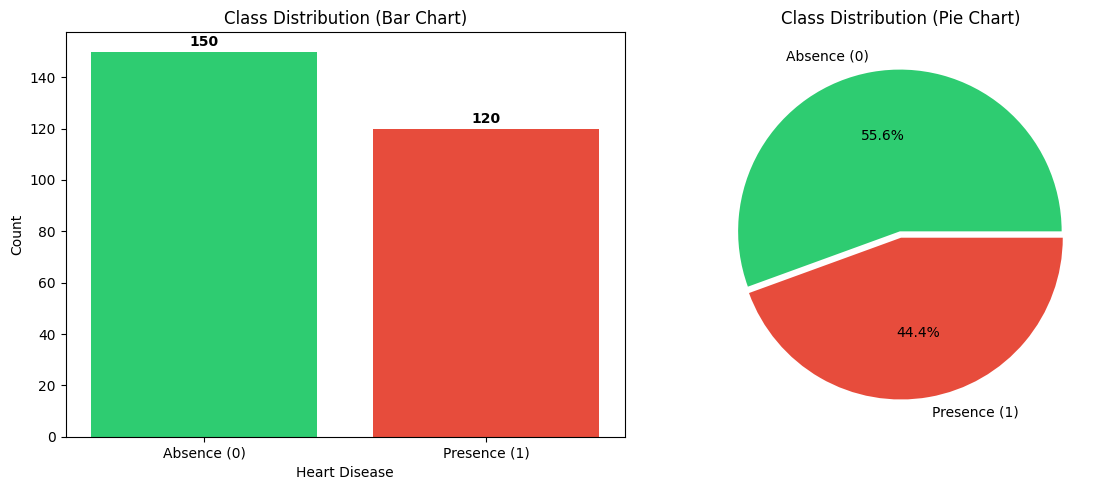


Class 0 (Absence): 150 (55.6%)
Class 1 (Presence): 120 (44.4%)


In [12]:
# Plot class distribution
print("="*60)
print("CLASS DISTRIBUTION")
print("="*60)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Bar plot
class_counts = df_clean['Heart Disease Binary'].value_counts()
colors = ['#2ecc71', '#e74c3c']
axes[0].bar(['Absence (0)', 'Presence (1)'], [class_counts[0], class_counts[1]], color=colors)
axes[0].set_xlabel('Heart Disease')
axes[0].set_ylabel('Count')
axes[0].set_title('Class Distribution (Bar Chart)')
for i, v in enumerate([class_counts[0], class_counts[1]]):
    axes[0].text(i, v + 2, str(v), ha='center', fontweight='bold')

# Pie chart
axes[1].pie([class_counts[0], class_counts[1]], 
            labels=['Absence (0)', 'Presence (1)'], 
            autopct='%1.1f%%',
            colors=colors,
            explode=(0.02, 0.02))
axes[1].set_title('Class Distribution (Pie Chart)')

plt.tight_layout()
plt.show()

print(f"\nClass 0 (Absence): {class_counts[0]} ({class_counts[0]/len(df_clean)*100:.1f}%)")
print(f"Class 1 (Presence): {class_counts[1]} ({class_counts[1]/len(df_clean)*100:.1f}%)")

## 3. Data Preparation

### Feature Selection (≥6 features)
Selected features:
1. **Age** - Patient age
2. **BP** - Blood Pressure
3. **Cholesterol** - Cholesterol level
4. **Max HR** - Maximum Heart Rate
5. **ST depression** - ST depression induced by exercise
6. **Number of vessels fluro** - Number of major vessels colored by fluoroscopy

In [13]:
# Select features and target
selected_features = ['Age', 'BP', 'Cholesterol', 'Max HR', 'ST depression', 'Number of vessels fluro']

X = df_clean[selected_features].values
y = df_clean['Heart Disease Binary'].values

print("="*60)
print("FEATURE SELECTION")
print("="*60)
print(f"\nSelected {len(selected_features)} features: {selected_features}")
print(f"\nFeature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")

FEATURE SELECTION

Selected 6 features: ['Age', 'BP', 'Cholesterol', 'Max HR', 'ST depression', 'Number of vessels fluro']

Feature matrix shape: (270, 6)
Target vector shape: (270,)


In [14]:
# Stratified Train/Test Split (70/30) - Manual implementation without sklearn
def stratified_train_test_split(X, y, test_size=0.3, random_seed=42):
    """
    Manual implementation of stratified train-test split.
    Ensures both train and test sets have similar class proportions.
    """
    np.random.seed(random_seed)
    
    # Get indices for each class
    class_0_indices = np.where(y == 0)[0]
    class_1_indices = np.where(y == 1)[0]
    
    # Shuffle indices
    np.random.shuffle(class_0_indices)
    np.random.shuffle(class_1_indices)
    
    # Calculate split points for each class
    n_test_class_0 = int(len(class_0_indices) * test_size)
    n_test_class_1 = int(len(class_1_indices) * test_size)
    
    # Split indices for each class
    test_indices_0 = class_0_indices[:n_test_class_0]
    train_indices_0 = class_0_indices[n_test_class_0:]
    
    test_indices_1 = class_1_indices[:n_test_class_1]
    train_indices_1 = class_1_indices[n_test_class_1:]
    
    # Combine indices
    train_indices = np.concatenate([train_indices_0, train_indices_1])
    test_indices = np.concatenate([test_indices_0, test_indices_1])
    
    # Shuffle combined indices
    np.random.shuffle(train_indices)
    np.random.shuffle(test_indices)
    
    # Create train and test sets
    X_train = X[train_indices]
    X_test = X[test_indices]
    y_train = y[train_indices]
    y_test = y[test_indices]
    
    return X_train, X_test, y_train, y_test

# Perform stratified split
X_train, X_test, y_train, y_test = stratified_train_test_split(X, y, test_size=0.3, random_seed=42)

print("="*60)
print("STRATIFIED TRAIN/TEST SPLIT (70/30)")
print("="*60)
print(f"\nTraining set: {X_train.shape[0]} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Test set: {X_test.shape[0]} samples ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"\nClass distribution in training set:")
print(f"  Class 0: {np.sum(y_train == 0)} ({np.sum(y_train == 0)/len(y_train)*100:.1f}%)")
print(f"  Class 1: {np.sum(y_train == 1)} ({np.sum(y_train == 1)/len(y_train)*100:.1f}%)")
print(f"\nClass distribution in test set:")
print(f"  Class 0: {np.sum(y_test == 0)} ({np.sum(y_test == 0)/len(y_test)*100:.1f}%)")
print(f"  Class 1: {np.sum(y_test == 1)} ({np.sum(y_test == 1)/len(y_test)*100:.1f}%)")

STRATIFIED TRAIN/TEST SPLIT (70/30)

Training set: 189 samples (70.0%)
Test set: 81 samples (30.0%)

Class distribution in training set:
  Class 0: 105 (55.6%)
  Class 1: 84 (44.4%)

Class distribution in test set:
  Class 0: 45 (55.6%)
  Class 1: 36 (44.4%)


In [15]:
# Feature Normalization (Min-Max Scaling) - Manual implementation
def min_max_normalize(X_train, X_test):
    """
    Manual implementation of Min-Max normalization.
    Fits on training data and transforms both train and test.
    Scales features to [0, 1] range.
    """
    # Calculate min and max from training data only
    X_min = X_train.min(axis=0)
    X_max = X_train.max(axis=0)
    
    # Avoid division by zero
    X_range = X_max - X_min
    X_range[X_range == 0] = 1  # If range is 0, keep original values
    
    # Normalize
    X_train_normalized = (X_train - X_min) / X_range
    X_test_normalized = (X_test - X_min) / X_range
    
    return X_train_normalized, X_test_normalized, X_min, X_range

# Normalize features
X_train_norm, X_test_norm, norm_min, norm_range = min_max_normalize(X_train, X_test)

print("="*60)
print("FEATURE NORMALIZATION (Min-Max Scaling)")
print("="*60)
print("\nNormalization parameters (from training data):")
for i, feat in enumerate(selected_features):
    print(f"  {feat}: min={norm_min[i]:.2f}, range={norm_range[i]:.2f}")

print("\n" + "-"*60)
print("Training set - Before vs After normalization:")
print("-"*60)
for i, feat in enumerate(selected_features):
    print(f"  {feat}:")
    print(f"    Before: min={X_train[:, i].min():.2f}, max={X_train[:, i].max():.2f}")
    print(f"    After:  min={X_train_norm[:, i].min():.2f}, max={X_train_norm[:, i].max():.2f}")

FEATURE NORMALIZATION (Min-Max Scaling)

Normalization parameters (from training data):
  Age: min=34.00, range=43.00
  BP: min=94.00, range=76.00
  Cholesterol: min=126.00, range=254.50
  Max HR: min=83.50, range=111.50
  ST depression: min=0.00, range=4.00
  Number of vessels fluro: min=0.00, range=2.50

------------------------------------------------------------
Training set - Before vs After normalization:
------------------------------------------------------------
  Age:
    Before: min=34.00, max=77.00
    After:  min=0.00, max=1.00
  BP:
    Before: min=94.00, max=170.00
    After:  min=0.00, max=1.00
  Cholesterol:
    Before: min=126.00, max=380.50
    After:  min=0.00, max=1.00
  Max HR:
    Before: min=83.50, max=195.00
    After:  min=0.00, max=1.00
  ST depression:
    Before: min=0.00, max=4.00
    After:  min=0.00, max=1.00
  Number of vessels fluro:
    Before: min=0.00, max=2.50
    After:  min=0.00, max=1.00


In [16]:
# Summary of prepared data
print("="*60)
print("DATA PREPARATION SUMMARY")
print("="*60)
print(f"\n✓ Loaded dataset with {len(df)} samples")
print(f"✓ Binarized target: Presence=1, Absence=0")
print(f"✓ Handled outliers using IQR capping method")
print(f"✓ Selected {len(selected_features)} features: {selected_features}")
print(f"✓ Stratified 70/30 split: {len(X_train)} train / {len(X_test)} test")
print(f"✓ Normalized features using Min-Max scaling")
print(f"\nFinal data shapes:")
print(f"  X_train_norm: {X_train_norm.shape}")
print(f"  X_test_norm: {X_test_norm.shape}")
print(f"  y_train: {y_train.shape}")
print(f"  y_test: {y_test.shape}")
print("\n✓ Data is ready for logistic regression model training!")

DATA PREPARATION SUMMARY

✓ Loaded dataset with 270 samples
✓ Binarized target: Presence=1, Absence=0
✓ Handled outliers using IQR capping method
✓ Selected 6 features: ['Age', 'BP', 'Cholesterol', 'Max HR', 'ST depression', 'Number of vessels fluro']
✓ Stratified 70/30 split: 189 train / 81 test
✓ Normalized features using Min-Max scaling

Final data shapes:
  X_train_norm: (189, 6)
  X_test_norm: (81, 6)
  y_train: (189,)
  y_test: (81,)

✓ Data is ready for logistic regression model training!


## 3. Implement Basic Logistic Regression

This section implements sigmoid, binary cross-entropy cost, gradient descent training, and evaluation metrics without using high-level ML libraries.

Iteration 500/2000 - Cost: 0.635019
Iteration 1000/2000 - Cost: 0.594495
Iteration 1500/2000 - Cost: 0.564691
Iteration 2000/2000 - Cost: 0.542274

Training complete.
Initial cost: 0.692992
Final cost:   0.542274


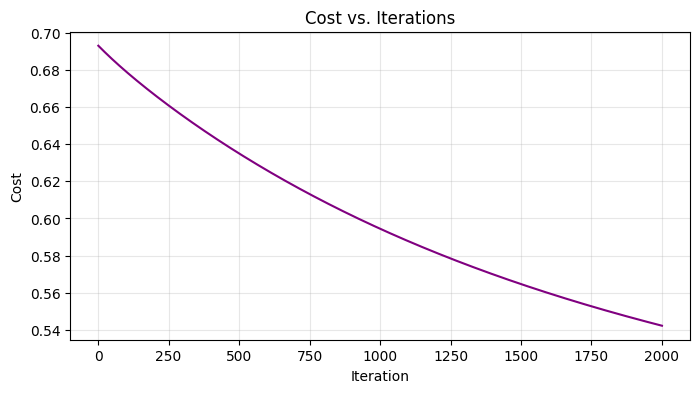


Metrics (threshold = 0.5):


,accuracy,precision,recall,f1
Train,0.783069,0.830769,0.642857,0.724832
Test,0.716049,0.740741,0.555556,0.634921



Top coefficients by absolute magnitude:


,feature,weight
6,Number of vessels fluro,1.019323
4,Max HR,-0.927572
5,ST depression,0.818829
0,bias,-0.407089
2,BP,0.314834
1,Age,0.209500
3,Cholesterol,0.106992



Convergence note: Cost decreased from 0.6930 to 0.5423.


In [18]:
# Sigmoid function

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# Add bias term (intercept)

def add_bias(X):
    return np.c_[np.ones((X.shape[0], 1)), X]

# Cost function (binary cross-entropy)

def compute_cost(X, y, w):
    m = X.shape[0]
    z = X @ w
    h = sigmoid(z)
    eps = 1e-15
    cost = -(1 / m) * np.sum(y * np.log(h + eps) + (1 - y) * np.log(1 - h + eps))
    return cost

# Gradients

def compute_gradients(X, y, w):
    m = X.shape[0]
    h = sigmoid(X @ w)
    grad = (1 / m) * (X.T @ (h - y))
    return grad

# Gradient Descent

def gradient_descent(X, y, alpha=0.01, num_iters=2000):
    w = np.zeros(X.shape[1])
    costs = []
    for i in range(num_iters):
        grad = compute_gradients(X, y, w)
        w -= alpha * grad
        costs.append(compute_cost(X, y, w))
        if (i + 1) % 500 == 0:
            print(f"Iteration {i+1}/{num_iters} - Cost: {costs[-1]:.6f}")
    return w, costs

# Prepare data for logistic regression
X_train_lr = add_bias(X_train_norm)
X_test_lr = add_bias(X_test_norm)

y_train_lr = np.array(y_train).reshape(-1)
y_test_lr = np.array(y_test).reshape(-1)

# Train model
alpha = 0.01
num_iters = 2000
w, cost_history = gradient_descent(X_train_lr, y_train_lr, alpha=alpha, num_iters=num_iters)

print("\nTraining complete.")
print(f"Initial cost: {cost_history[0]:.6f}")
print(f"Final cost:   {cost_history[-1]:.6f}")

# Plot cost vs iterations
plt.figure(figsize=(8, 4))
plt.plot(range(1, num_iters + 1), cost_history, color='purple')
plt.title("Cost vs. Iterations")
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.grid(True, alpha=0.3)
plt.show()

# Prediction helpers

def predict_proba(X, w):
    return sigmoid(X @ w)


def predict(X, w, threshold=0.5):
    return (predict_proba(X, w) >= threshold).astype(int)

# Metrics

def classification_metrics(y_true, y_pred):
    tp = np.sum((y_true == 1) & (y_pred == 1))
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1 = (2 * precision * recall / (precision + recall)) if (precision + recall) > 0 else 0.0

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "tp": tp,
        "tn": tn,
        "fp": fp,
        "fn": fn
    }

# Evaluate on train and test
train_pred = predict(X_train_lr, w, threshold=0.5)
test_pred = predict(X_test_lr, w, threshold=0.5)

train_metrics = classification_metrics(y_train_lr, train_pred)
test_metrics = classification_metrics(y_test_lr, test_pred)

metrics_df = pd.DataFrame(
    [train_metrics, test_metrics],
    index=["Train", "Test"]
)[["accuracy", "precision", "recall", "f1"]]

print("\nMetrics (threshold = 0.5):")
display(metrics_df)

# Coefficient interpretation
feature_names = ["bias"] + selected_features
coef_df = pd.DataFrame({
    "feature": feature_names,
    "weight": w
}).sort_values(by="weight", key=lambda s: np.abs(s), ascending=False)

print("\nTop coefficients by absolute magnitude:")
display(coef_df.head(10))

# Simple convergence comment
trend = "decreased" if cost_history[-1] < cost_history[0] else "did not decrease"
print(f"\nConvergence note: Cost {trend} from {cost_history[0]:.4f} to {cost_history[-1]:.4f}.")

## 4. Repeat with Regularization (L2)

We add L2 regularization to the cost and gradients, tune $\lambda$ over a small grid, compare metrics and weight norms, and visualize cost/decision boundary for one pair (unregularized vs. regularized).

[λ=0] Iter 500/2000 - Cost: 0.635019
[λ=0] Iter 1000/2000 - Cost: 0.594495
[λ=0] Iter 1500/2000 - Cost: 0.564691
[λ=0] Iter 2000/2000 - Cost: 0.542274
[λ=0.001] Iter 500/2000 - Cost: 0.635020
[λ=0.001] Iter 1000/2000 - Cost: 0.594499
[λ=0.001] Iter 1500/2000 - Cost: 0.564699
[λ=0.001] Iter 2000/2000 - Cost: 0.542286
[λ=0.01] Iter 500/2000 - Cost: 0.635032
[λ=0.01] Iter 1000/2000 - Cost: 0.594538
[λ=0.01] Iter 1500/2000 - Cost: 0.564771
[λ=0.01] Iter 2000/2000 - Cost: 0.542394
[λ=0.1] Iter 500/2000 - Cost: 0.635149
[λ=0.1] Iter 1000/2000 - Cost: 0.594922
[λ=0.1] Iter 1500/2000 - Cost: 0.565490
[λ=0.1] Iter 2000/2000 - Cost: 0.543470
[λ=1] Iter 500/2000 - Cost: 0.636298
[λ=1] Iter 1000/2000 - Cost: 0.598642
[λ=1] Iter 1500/2000 - Cost: 0.572339
[λ=1] Iter 2000/2000 - Cost: 0.553575

Lambda tuning results:


,lambda,train_accuracy,train_precision,train_recall,train_f1,test_accuracy,test_precision,test_recall,test_f1,||w||
0,0.000,0.783069,0.830769,0.642857,0.724832,0.716049,0.740741,0.555556,0.634921,1.650559
1,0.001,0.783069,0.830769,0.642857,0.724832,0.716049,0.740741,0.555556,0.634921,1.650480
2,0.010,0.783069,0.830769,0.642857,0.724832,0.716049,0.740741,0.555556,0.634921,1.649770
3,0.100,0.783069,0.830769,0.642857,0.724832,0.716049,0.740741,0.555556,0.634921,1.642685
4,1.000,0.788360,0.843750,0.642857,0.729730,0.716049,0.740741,0.555556,0.634921,1.574213


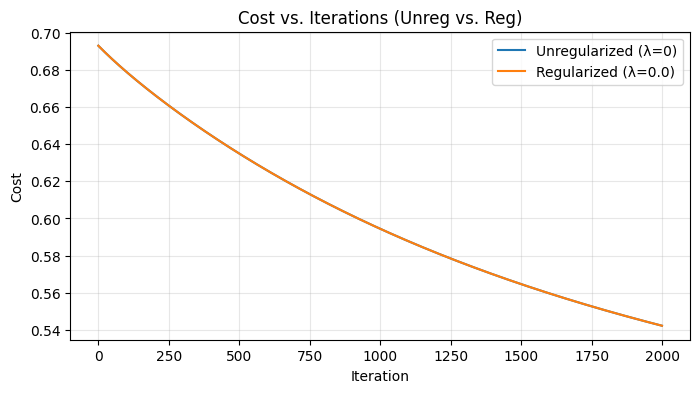

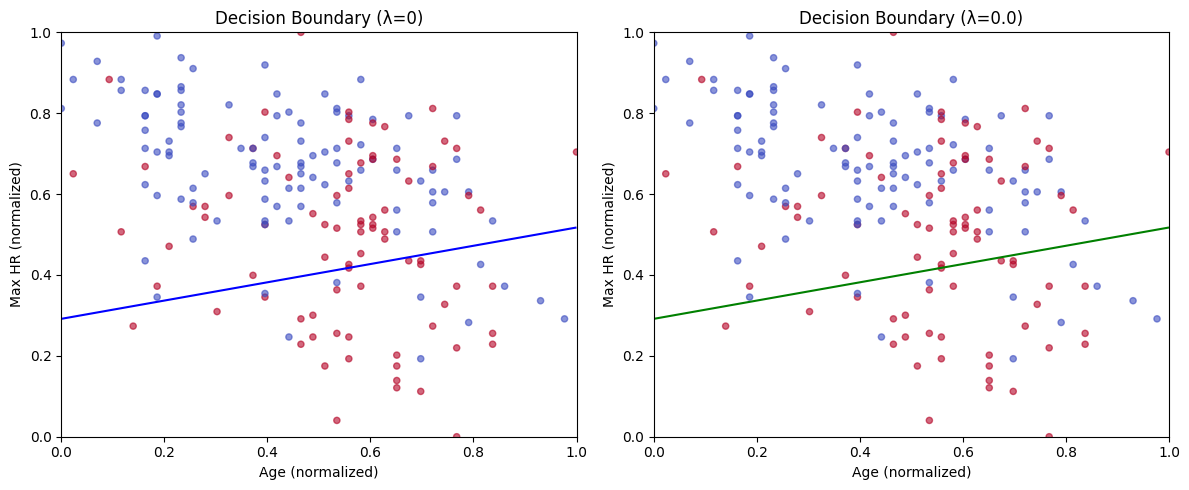


Optimal λ=0.0 improves test F1 by 0.00%.


In [20]:
# L2-regularized cost and gradients (exclude bias term from regularization)

def compute_cost_reg(X, y, w, lam):
    m = X.shape[0]
    base = compute_cost(X, y, w)
    reg = (lam / (2 * m)) * np.sum(w[1:] ** 2)
    return base + reg


def compute_gradients_reg(X, y, w, lam):
    m = X.shape[0]
    grad = compute_gradients(X, y, w)
    reg = (lam / m) * w
    reg[0] = 0  # don't regularize bias
    return grad + reg


def gradient_descent_reg(X, y, alpha=0.01, num_iters=2000, lam=0.0):
    w = np.zeros(X.shape[1])
    costs = []
    for i in range(num_iters):
        grad = compute_gradients_reg(X, y, w, lam)
        w -= alpha * grad
        costs.append(compute_cost_reg(X, y, w, lam))
        if (i + 1) % 500 == 0:
            print(f"[λ={lam}] Iter {i+1}/{num_iters} - Cost: {costs[-1]:.6f}")
    return w, costs

# Tune lambda values
lambda_values = [0, 0.001, 0.01, 0.1, 1]

results = []
models = {}

for lam in lambda_values:
    w_lam, costs_lam = gradient_descent_reg(X_train_lr, y_train_lr, alpha=alpha, num_iters=num_iters, lam=lam)
    train_pred_lam = predict(X_train_lr, w_lam, threshold=0.5)
    test_pred_lam = predict(X_test_lr, w_lam, threshold=0.5)

    train_m = classification_metrics(y_train_lr, train_pred_lam)
    test_m = classification_metrics(y_test_lr, test_pred_lam)

    results.append({
        "lambda": lam,
        "train_accuracy": train_m["accuracy"],
        "train_precision": train_m["precision"],
        "train_recall": train_m["recall"],
        "train_f1": train_m["f1"],
        "test_accuracy": test_m["accuracy"],
        "test_precision": test_m["precision"],
        "test_recall": test_m["recall"],
        "test_f1": test_m["f1"],
        "||w||": float(np.linalg.norm(w_lam[1:]))
    })

    models[lam] = {"w": w_lam, "costs": costs_lam}

results_df = pd.DataFrame(results)
print("\nLambda tuning results:")
display(results_df)

# Pick best lambda by test F1 (ties -> smaller lambda)
best_row = results_df.sort_values(by=["test_f1", "lambda"], ascending=[False, True]).iloc[0]
best_lambda = best_row["lambda"]

# Compare unregularized vs best regularized costs
costs_unreg = models[0]["costs"]
costs_reg = models[best_lambda]["costs"]

plt.figure(figsize=(8, 4))
plt.plot(costs_unreg, label="Unregularized (λ=0)")
plt.plot(costs_reg, label=f"Regularized (λ={best_lambda})")
plt.title("Cost vs. Iterations (Unreg vs. Reg)")
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Decision boundary visualization for two features (holding others at mean)
# Choose two features to plot
feat_x, feat_y = "Age", "Max HR"
idx_x = selected_features.index(feat_x)
idx_y = selected_features.index(feat_y)

# Grid in normalized space
x_min, x_max = X_train_norm[:, idx_x].min(), X_train_norm[:, idx_x].max()
y_min, y_max = X_train_norm[:, idx_y].min(), X_train_norm[:, idx_y].max()
xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 200),
    np.linspace(y_min, y_max, 200)
)

# Build full feature vectors with other features set to mean
mean_features = X_train_norm.mean(axis=0)

# Create grid data
grid = np.tile(mean_features, (xx.size, 1))
grid[:, idx_x] = xx.ravel()
grid[:, idx_y] = yy.ravel()

grid_bias = add_bias(grid)

# Predict probabilities for unreg and reg
probs_unreg = predict_proba(grid_bias, models[0]["w"]).reshape(xx.shape)
probs_reg = predict_proba(grid_bias, models[best_lambda]["w"]).reshape(xx.shape)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.contour(xx, yy, probs_unreg, levels=[0.5], colors="blue")
plt.scatter(X_train_norm[:, idx_x], X_train_norm[:, idx_y], c=y_train_lr, cmap="coolwarm", s=20, alpha=0.6)
plt.title("Decision Boundary (λ=0)")
plt.xlabel(f"{feat_x} (normalized)")
plt.ylabel(f"{feat_y} (normalized)")

plt.subplot(1, 2, 2)
plt.contour(xx, yy, probs_reg, levels=[0.5], colors="green")
plt.scatter(X_train_norm[:, idx_x], X_train_norm[:, idx_y], c=y_train_lr, cmap="coolwarm", s=20, alpha=0.6)
plt.title(f"Decision Boundary (λ={best_lambda})")
plt.xlabel(f"{feat_x} (normalized)")
plt.ylabel(f"{feat_y} (normalized)")

plt.tight_layout()
plt.show()

# Reporting statement
base_metric = results_df.loc[results_df["lambda"] == 0, "test_f1"].iloc[0]
best_metric = best_row["test_f1"]
if base_metric > 0:
    improvement = (best_metric - base_metric) / base_metric * 100
else:
    improvement = 0.0

print(f"\nOptimal λ={best_lambda} improves test F1 by {improvement:.2f}%.")


## 5. Export Model for Deployment

Export the best model (with optimal λ) as NumPy arrays and create an inference function for patient predictions in Amazon SageMaker.

In [22]:
# Extract best model parameters
best_w = models[best_lambda]["w"]
bias = best_w[0]
weights = best_w[1:]

print("="*60)
print("EXPORT BEST MODEL")
print("="*60)
print(f"\nBest regularization parameter: λ = {best_lambda}")
print(f"\nModel parameters (NumPy arrays):")
print(f"  Bias: {bias:.6f}")
print(f"  Weights shape: {weights.shape}")
print(f"  Weights:\n{weights}")

# Save model to file (optional)
import json

model_dict = {
    "bias": float(bias),
    "weights": weights.tolist(),
    "feature_names": selected_features,
    "normalization": {
        "min": norm_min.tolist(),
        "range": norm_range.tolist()
    },
    "lambda": float(best_lambda),
    "features": len(selected_features)
}

# Save as JSON for easy loading in SageMaker
with open("heart_disease_model.json", "w") as f:
    json.dump(model_dict, f, indent=2)

print("\n✓ Model saved to 'heart_disease_model.json'")

# Create inference function
def predict_patient_risk(patient_features_raw, model_dict):
    """
    Predict heart disease risk for a single patient.
    
    Args:
        patient_features_raw: dict with keys matching selected_features
        model_dict: exported model dictionary
    
    Returns:
        dict with probability and prediction
    """
    # Extract model parameters
    bias = model_dict["bias"]
    weights = np.array(model_dict["weights"])
    norm_min = np.array(model_dict["normalization"]["min"])
    norm_range = np.array(model_dict["normalization"]["range"])
    
    # Prepare feature vector
    features = [patient_features_raw[feat] for feat in model_dict["feature_names"]]
    features = np.array(features).reshape(1, -1)
    
    # Normalize
    features_norm = (features - norm_min) / norm_range
    
    # Add bias
    features_with_bias = np.c_[np.ones(1), features_norm]
    
    # Predict
    prob = sigmoid(features_with_bias @ np.concatenate([[bias], weights]))[0]
    prediction = 1 if prob >= 0.5 else 0
    
    return {
        "probability": float(prob),
        "prediction": prediction,
        "risk_level": "High" if prediction == 1 else "Low"
    }

# Test inference function with example patient
example_patient = {
    "Age": 50,
    "BP": 120,
    "Cholesterol": 200,
    "Max HR": 150,
    "ST depression": 1.0,
    "Number of vessels fluro": 1
}

result = predict_patient_risk(example_patient, model_dict)
print("\n" + "="*60)
print("INFERENCE EXAMPLE")
print("="*60)
print(f"\nTest patient features: {example_patient}")
print(f"\nPrediction: {result}")
print(f"  Probability of disease: {result['probability']:.4f}")
print(f"  Risk level: {result['risk_level']}")

# Save inference script for SageMaker
inference_script = '''
import json
import numpy as np

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def predict_patient_risk(patient_features_raw, model_dict):
    """
    Predict heart disease risk for patient inputs.
    """
    bias = model_dict["bias"]
    weights = np.array(model_dict["weights"])
    norm_min = np.array(model_dict["normalization"]["min"])
    norm_range = np.array(model_dict["normalization"]["range"])
    
    features = [patient_features_raw[feat] for feat in model_dict["feature_names"]]
    features = np.array(features).reshape(1, -1)
    
    features_norm = (features - norm_min) / norm_range
    features_with_bias = np.c_[np.ones(1), features_norm]
    
    prob = sigmoid(features_with_bias @ np.concatenate([[bias], weights]))[0]
    prediction = 1 if prob >= 0.5 else 0
    
    return {
        "probability": float(prob),
        "prediction": prediction,
        "risk_level": "High" if prediction == 1 else "Low"
    }

def lambda_handler(event, context):
    """AWS Lambda handler for SageMaker endpoint."""
    # Load model
    with open("heart_disease_model.json", "r") as f:
        model_dict = json.load(f)
    
    # Get patient data from request
    patient_features = event["body"]
    
    # Predict
    result = predict_patient_risk(patient_features, model_dict)
    
    return {
        "statusCode": 200,
        "body": json.dumps(result)
    }
'''

with open("inference_handler.py", "w") as f:
    f.write(inference_script)

print("\n✓ Inference script saved to 'inference_handler.py'")
print("\nFor SageMaker deployment:")
print("  1. Upload 'heart_disease_model.json' to S3")
print("  2. Create a SageMaker notebook instance")
print("  3. Load the model and run inference via endpoint")
print("  4. Use 'inference_handler.py' as reference for Lambda handler")

EXPORT BEST MODEL

Best regularization parameter: λ = 0.0

Model parameters (NumPy arrays):
  Bias: -0.407089
  Weights shape: (6,)
  Weights:
[ 0.20949968  0.31483414  0.10699218 -0.92757171  0.81882866  1.01932278]

✓ Model saved to 'heart_disease_model.json'

INFERENCE EXAMPLE

Test patient features: {'Age': 50, 'BP': 120, 'Cholesterol': 200, 'Max HR': 150, 'ST depression': 1.0, 'Number of vessels fluro': 1}

Prediction: {'probability': 0.46727212822748077, 'prediction': 0, 'risk_level': 'Low'}
  Probability of disease: 0.4673
  Risk level: Low

✓ Inference script saved to 'inference_handler.py'

For SageMaker deployment:
  1. Upload 'heart_disease_model.json' to S3
  2. Create a SageMaker notebook instance
  3. Load the model and run inference via endpoint
  4. Use 'inference_handler.py' as reference for Lambda handler
